# Computation of seismogram in 3D homogeneous model

Small example to compute seismic wave propagation in homogeneous elastic model. 


## 1. Setup in local computer

Creation of new pyspecfem setup file.<br>
Use class SpecfemProject from pyspecfem to define general configuration.

In [1]:
from PySpecfem.SpecfemProject import *
spe = SpecfemProject()

### Define computational domain

Define the cartesian domain for computation. 
> [xmin, xmax, ymin, ymax, zmin, zmax] 

in meters

In [2]:
domain = [-15000., 15000., -15000., 15000., -15000., 0.]

Define the size of element. 
> [dx, dy, dz]

in meters

In [3]:
element_size = [1000., 1000., 1000.]

Setup domain in SpecfemProject class

In [4]:
spe.setup_domain(coords_system = "cartesian",
                 extent = domain,
                 size_elem = element_size,
                 use_sponge = 1,                                # use sponge absorbing layers
                 absorbing_sponge = [3000., 3000., 3000., 0.01] # absorbing layer (~3 elements), absorbtion coef 0.01
                )

### Define materials
The simulation is performed in elastic istroic material defined by :
> Density  = 2340 Kg/m^3<br>
> P-wave velocity = 3780 m/s <br>
> S-wave velocity = 2100 m/s <br>
> the attenuation and ansisotropy is not used then we set the quality factor to 9999 and anisotropic flag to 0 

In [5]:
material_1 = [1, 2340, 3780, 2100, 9999, 0] # material properties 
sub_domain_1 = [1, -15000., 15000., -15000., 15000., -15000., 0.] # domain with material_1

In [6]:
spe.setup_model(model_type = "default",
                number_of_material = 1,
                material_params = [material_1],
                number_of_domain = 1,
                domain_info=[sub_domain_1])

using mannual material setup.


### Mesh
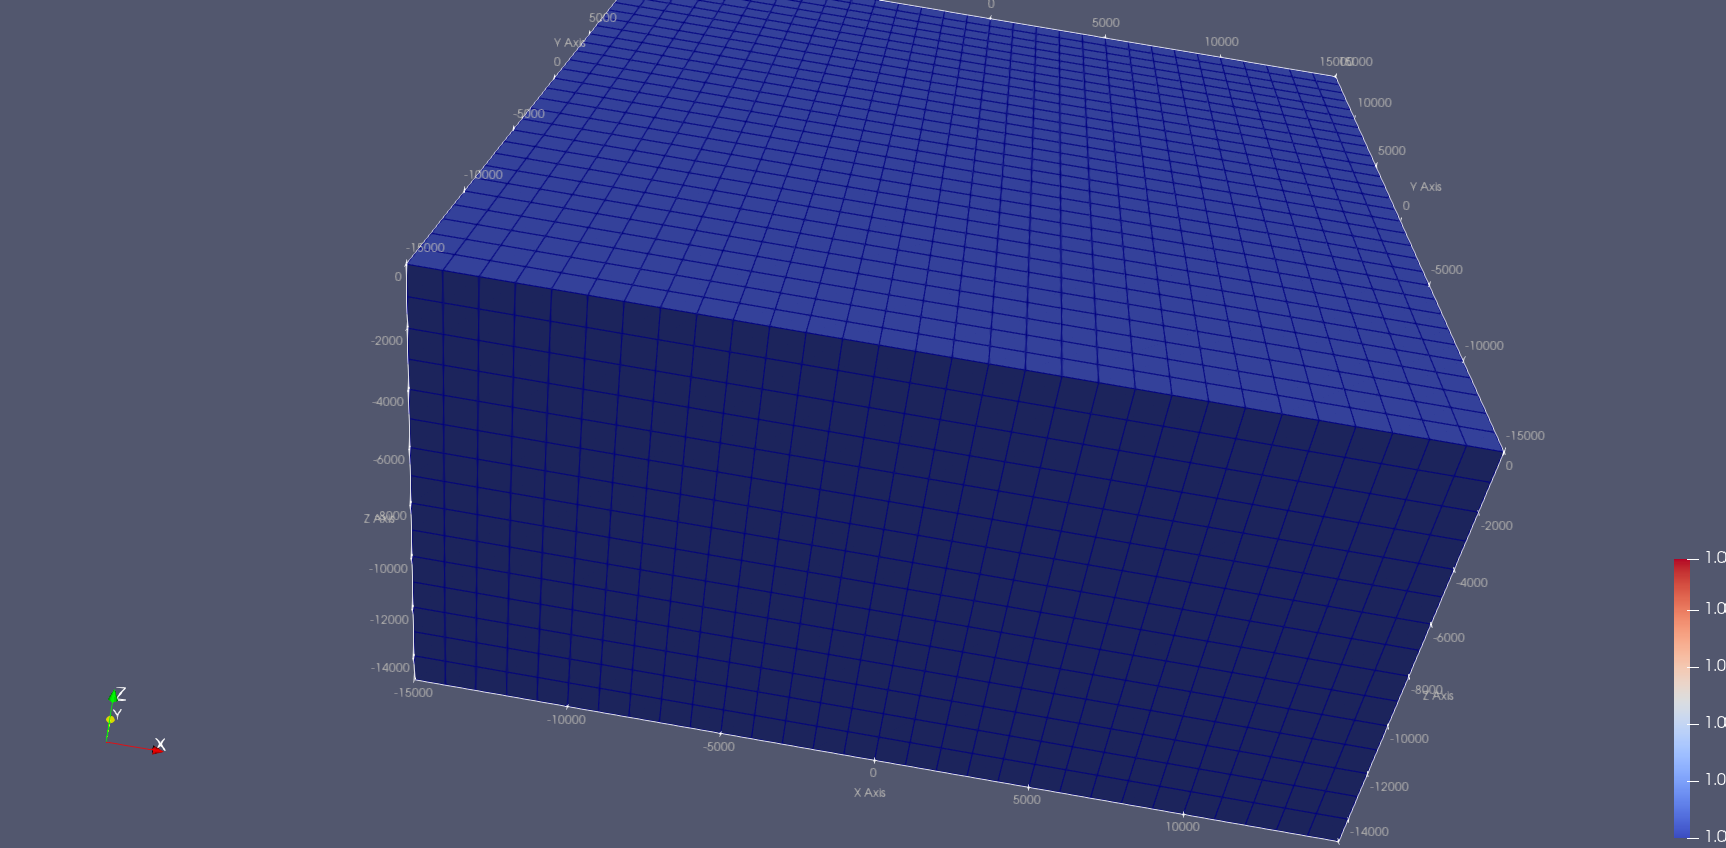

### Define seismic stations

we are using a line of receivers at the surface : 

In [7]:
spe.setup_station(station_type = "station_grid",
                  station_origin = [-10250., 502., 0.], # position of the fisrt station
                  station_step = [500., 0., 0.],        # one station every 500 m in x direction
                  station_number = [60, 1, 1])          # 60 stations on x direction

using default station setup.


### Define seismic source

In [8]:
spe.setup_source(source_type= "shot_grid",               # shot sources  
                 source_origin = [-100., -200., -6200.],
                 source_step = [ 0., 0., 0.],
                 source_number = [1, 1, 1],
                 source_ampl = 1e20,                     # amplitude of the source
                 ricker_f0 = 1.5,                        # dominant frequency of the source
                 t_shift = -1.)                          # time delay for the source time function

### Visualize the current status

In [9]:
from PySpecfem.vis_project import SpecToVista

vspe = SpecToVista(spe)
vspe.plot_3d()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Define path to thde specfem code in the remote cluster

In [10]:
spe.setup_path(specfem_directory="/shared/cheese/specfem3d/specfem_fwi")

### Setup parameters for simulation

In [11]:
spe.setup_specfem_config(number_of_mpi_domain = 8,
                         time_length = 15.,
                         time_step = 0.0025,     # sampling for simulation constrained by CFL
                         time_step_data = 0.05,  # sesimogram sampling
                         hdf5_enabled = 0,
                         use_gpu = 0)

### Choose scripts to launch : 
default : simple interactive bash scripts 
trainning_cluster : pbs scripts for the taining cluster    

In [12]:
spe.setup_script(script_type = "pbs")

### Write the configuration file 

In [13]:
spe.write_setup_file()
!ls

Homogeneous_model.ipynb  setup_file.in


## 2. Computation in remote training cluster

### Upload configuration file in remote training cluster
Upload setup_file.in in the cluster in directory where specfem will be launch (replace "login@cluster" and  "path_to_directory_to_run" with proper values)

In [14]:
#!scp setup_file.in login@cluster:path_to_directory_to_run
!scp setup_file.in sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/homogeneous/.
#!cp setup_file.in /home/vmont/run/EXAMPLES_SPECFEM_FWI/ChEESE_TRANING/homogeneous/.


lost connection


### Setup the specfem run

Open a terminal on the remote cluster. Go to directory "path_to_directory_to_run"

> pyspecfem_setup setup_file.in

Now the specfem tools are ready to run in the remote cluster

### launch mesher
> qsub run_meshfem3D_1.batch
### launch solver setup
> qsub run_generate_databases_2.batch
### launch simulation
> qsub run_FWI_forward.bash



## 3. Post-process in local computer

### Download the results from remote cluster

In [15]:
%%bash
run_directory="/shared/training/ws/sca50903-specfem3d_scratch/homogeneous/"
echo $run_directory
scp  sca50903@training.hlrs.de:/$run_directory/DATA_DIR/EV_1/Gather.bin .
scp  sca50903@training.hlrs.de:/$run_directory/DATA_DIR/EV_1/Gather.bin.hdr .  
scp  sca50903@training.hlrs.de:/$run_directory/DATA_DIR/EV_1/STATIONS_FILTERED .  

/shared/training/ws/sca50903-specfem3d_scratch/homogeneous/


sca50903@training.hlrs.de: Permission denied (publickey,hostbased).
sca50903@training.hlrs.de: Permission denied (publickey,hostbased).
sca50903@training.hlrs.de: Permission denied (publickey,hostbased).


CalledProcessError: Command 'b'run_directory="/shared/training/ws/sca50903-specfem3d_scratch/homogeneous/"\necho $run_directory\nscp  sca50903@training.hlrs.de:/$run_directory/DATA_DIR/EV_1/Gather.bin .\nscp  sca50903@training.hlrs.de:/$run_directory/DATA_DIR/EV_1/Gather.bin.hdr .  \nscp  sca50903@training.hlrs.de:/$run_directory/DATA_DIR/EV_1/STATIONS_FILTERED .  \n'' returned non-zero exit status 1.

### Display seismogram 

In [ ]:
from PySpecfem.helper.sismograms import SismoGather
# class for managing seismograms
synth0 =  SismoGather(verb=False)
# directory where seismograms are downloaded
directory_with_files= "./"
# name of binary file with computed seismograms
file_with_sythetics = "Gather.bin"
# metadata associated with seismograms
metadata_file = "Gather.bin.hdr"
# read computed seismograms
synth0.read_inputs(directory_with_files, file_with_sythetics, metadata_file)

Plotting raw seismograms 

<IPython.core.display.Javascript object>


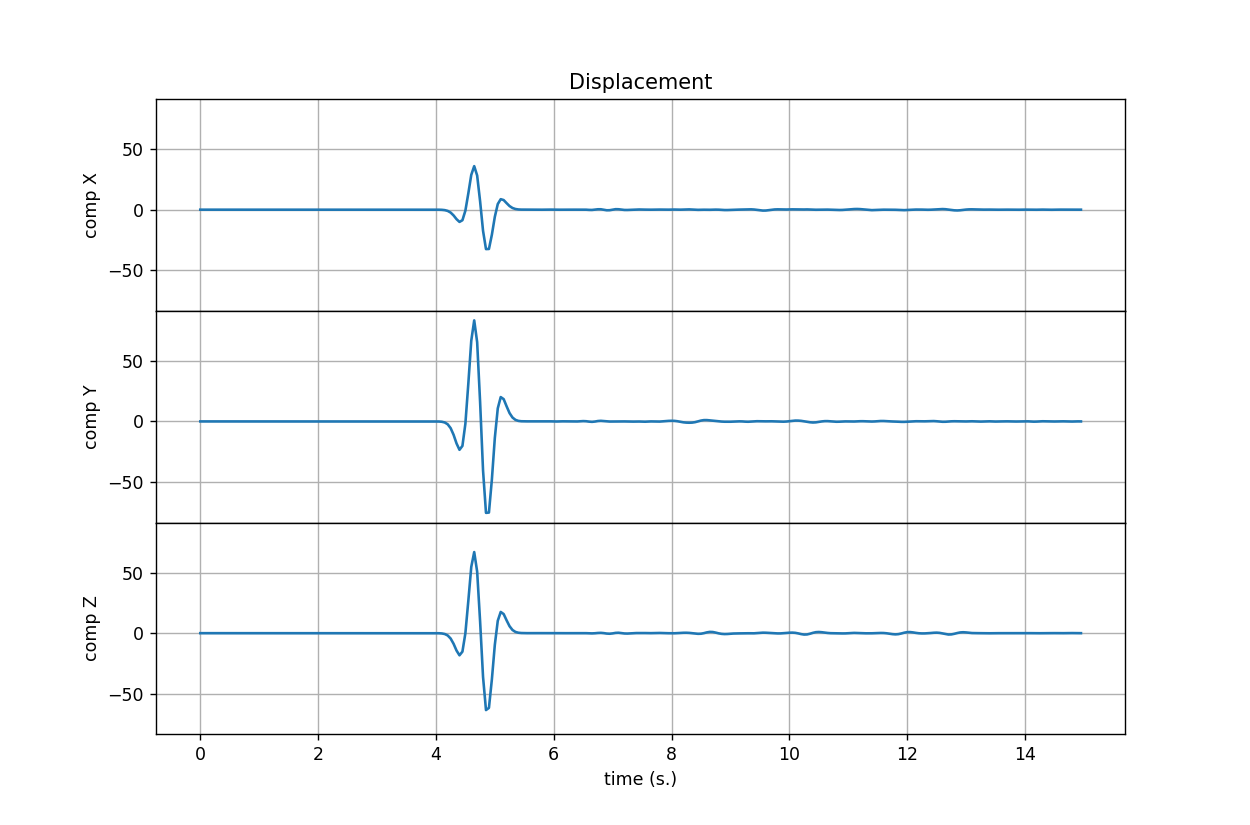

In [ ]:
%matplotlib notebook
%matplotlib notebook
# display 3 components in time domain
synth0.display_sismogram(irec=0)

<IPython.core.display.Javascript object>


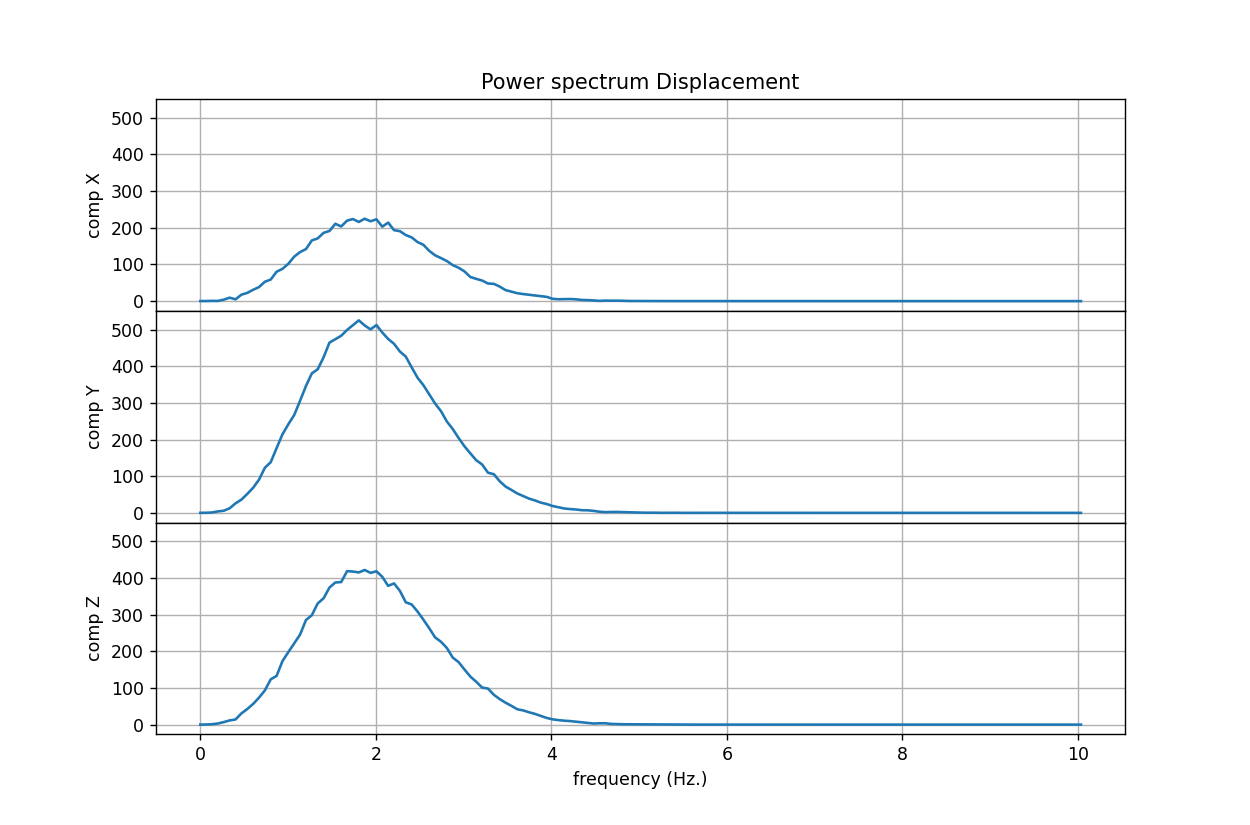

In [ ]:
%matplotlib notebook
%matplotlib notebook
# display seismograms in frequency domain
synth0.display_spectrum(irec=0)

## 4. 3D movie 
### VZ snapshot
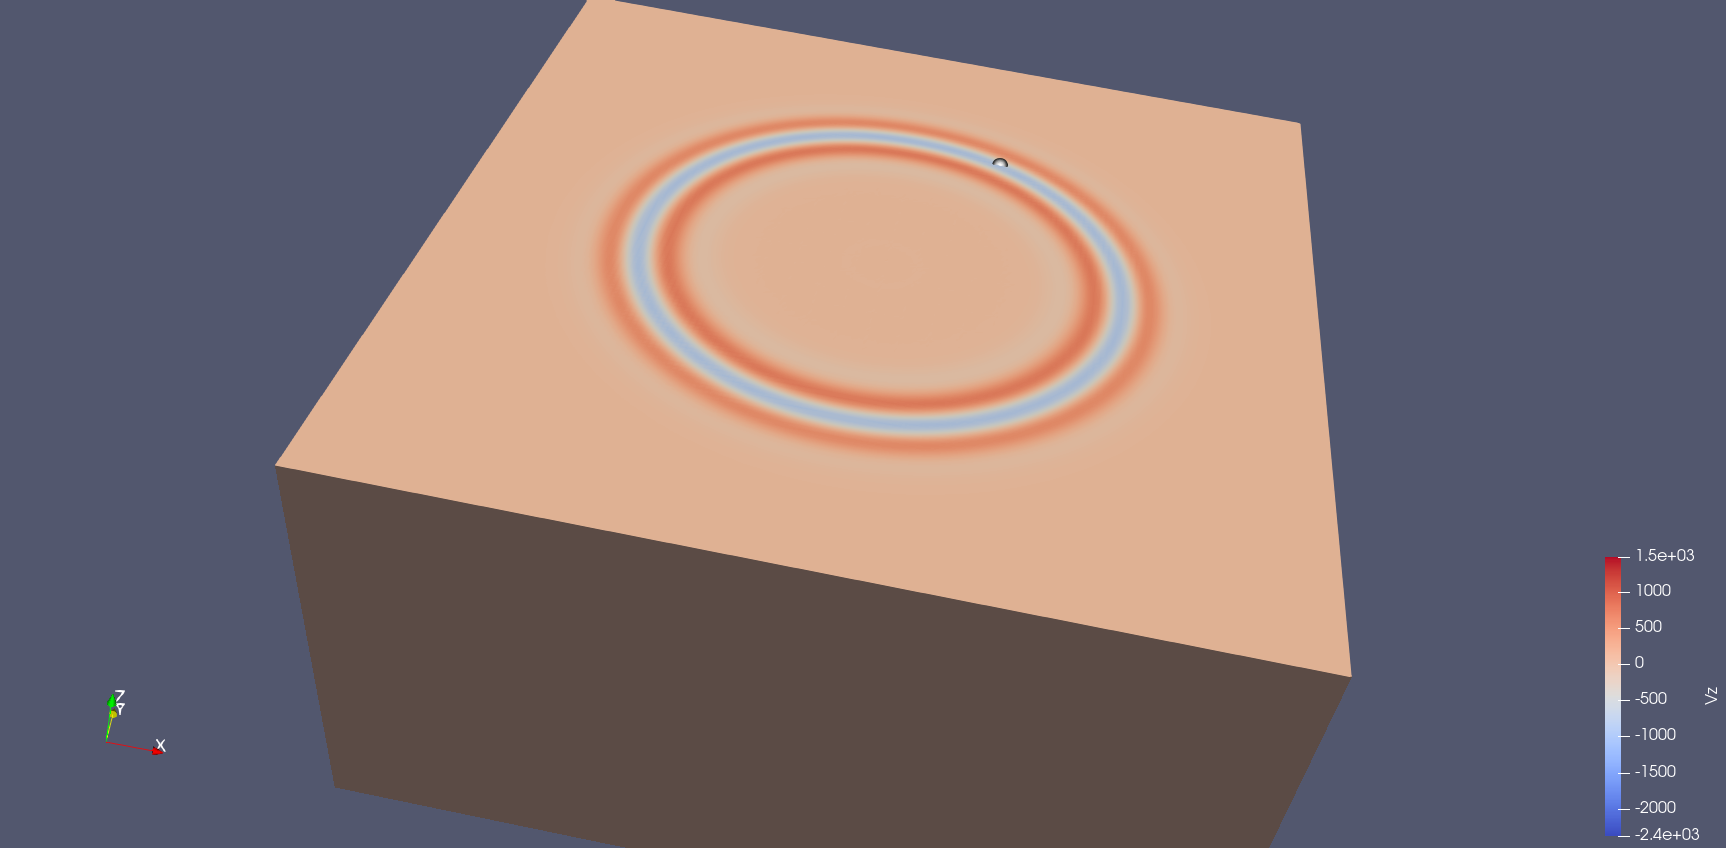

To visualize snapshots, the movie parameter in specfem need to be set to true. In running directory on remote cluster edit the file DATA/Par_file and modify the folowing lines <br>
> line 139 : MOVIE_VOLUME                    = .true. <br>
> line 141 : NSTEP_BETWEEN_FRAMES           = 1000     <br>
> line 143 : HDUR_MOVIE                      = 0.01   <br>


And launch again the simulation. 

### Download snapshots 

In [ ]:
%%bash
run_directory="/shared/training/ws/sca50903-specfem3d_scratch/homogeneous/"
echo $run_directory
mkdir DATABASES_MPI
scp sca50903@training.hlrs.de:$run_directory/veloc.xdmf .
scp sca50903@training.hlrs.de:$run_directory/DATABASES_MPI/*_grid.bin DATABASES_MPI/.
scp sca50903@training.hlrs.de:$run_directory/DATABASES_MPI/*_points.bin DATABASES_MPI/.
scp sca50903@training.hlrs.de:$run_directory/DATABASES_MPI/*_veloc_*.bin DATABASES_MPI/.

Open file "veloc.xdmf" with paraview. 